### This notebook runs GI-Sim tool by using stored models 
- Codes to run GI-Sim
- Repository page: https://github.com/shantanuneema/geo_image_problem

#### Prepared by: Shantanu Neema (Cummins Inc.)

### Instructions

1. Any user can use this tool by clicking **Kernel -> Restart & Run All**
2. Choose a already loaded model in /models folder (Created during model development)
3. User will be able to choose the distance type (Cosine or Euclidean) for similarity algorithm
3. User can select image index number and K (desired top similar images)

#### Notes:
- This notebook can be used only if using either resnet18, resnet34 or resnet50 as the model architecture
- Users may use image index number and desired input for K as many time they wish, the images will keep appending in the notebook

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import HTML, display
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code Visibility"></form>''')

In [3]:
import os
import time
import ipywidgets as wg
from ipywidgets import *
import pathlib
from pathlib import Path
from fastai.vision import *
from IPython.display import Image

working_folder = str(pathlib.Path.cwd().parent) + '/src/'
os.chdir(working_folder)

import GI_config as conf_lib
import GI_load as load_lib
import GI_lib as lib

model_path = str(Path(working_folder).parent) + '/geological_similarity/models/'

In [4]:
saved_model_options = [file for file in os.listdir(model_path) if file.endswith('.pth')]
model_options = sorted([file.replace('.pth', '') for file in saved_model_options])

model_selection = wg.Dropdown(options=['']+model_options,
                              value='',
                              description='Choose Model:',
                              style={'description_width': 'initial'},
                              layout=Layout(width='300px',height='25px'),
                              disabled=False)
model_selection

Dropdown(description='Choose Model:', layout=Layout(height='25px', width='300px'), options=('', 'best', 'model…

In [5]:
architecture = wg.Dropdown(options=['resnet18', 'resnet34', 'resnet50'],
                              value='resnet34',
                              description='Choose model type:',
                              style={'description_width': 'initial'},
                              layout=Layout(width='300px',height='25px'),
                              disabled=False)
architecture

Dropdown(description='Choose model type:', index=1, layout=Layout(height='25px', width='300px'), options=('res…

In [6]:
dist_type = wg.RadioButtons(options=['Cosine', 'Euclidean'],
                            value='Cosine',
                            disabled=False)
HBox([Label('Choose distance type'), dist_type])

In [7]:
img_index = wg.Textarea(
    value='',
    placeholder='Type index number',
    disabled=False)
Box1 = VBox([Label('Image Index'), img_index])

top_k = wg.Textarea(
    value='',
    placeholder='Type how many similar images needed',
    disabled=False)
Box2 = VBox([Label('K'), top_k])

Button(description='Load & Run the Model', layout=Layout(height='35px', width='250px'), style=ButtonStyle())

Data is stored as train, test & validation folders in /home/pr916/notebooks/geo_image_problem
geological image data loaded
collecting all images ...
making image dataframe ...
Indexes in order of  ['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']
first indexes of each class type: [0, 3500, 7000, 10498, 13998, 17498]
first indexes of each class type: [20998, 21748, 22498, 23247, 23997, 24747]
first indexes of each class type: [25497, 26247, 26997, 27748, 28498, 29248]
maximum image index: 29984
-------- 246 seconds --------


Button(description='Show Results', style=ButtonStyle())

gneiss
/home/pr916/notebooks/geo_image_problem/geological_similarity/valid/gneiss/2WHKD.jpg


Images similar to above based on Euclidean distance: 


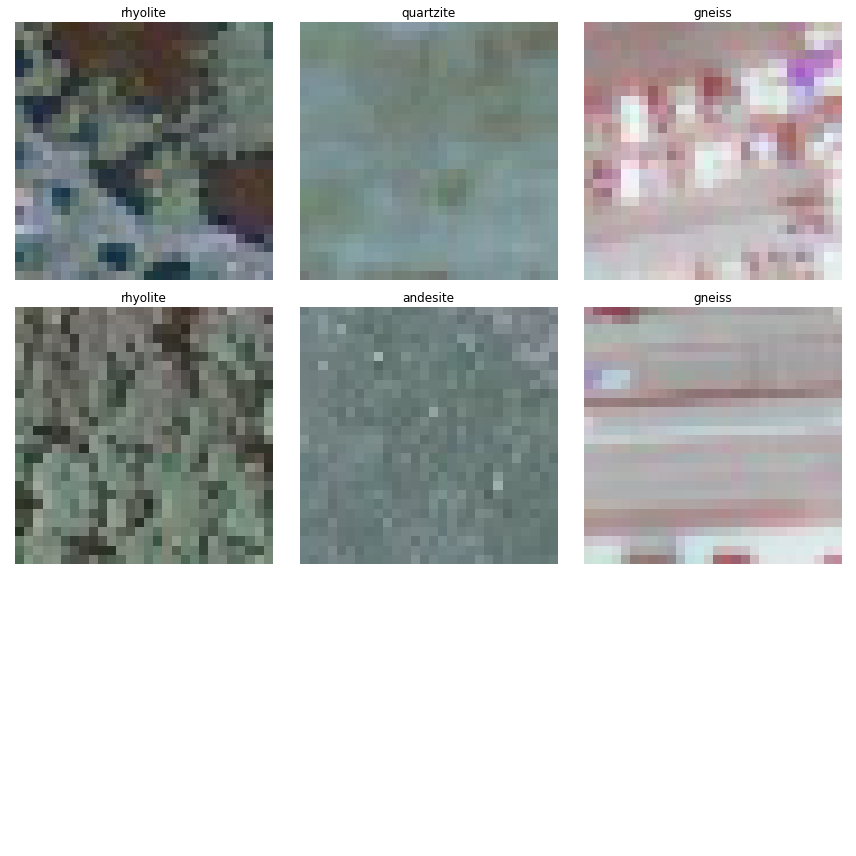

andesite
/home/pr916/notebooks/geo_image_problem/geological_similarity/train/andesite/ZA6W4.jpg


Images similar to above based on Euclidean distance: 


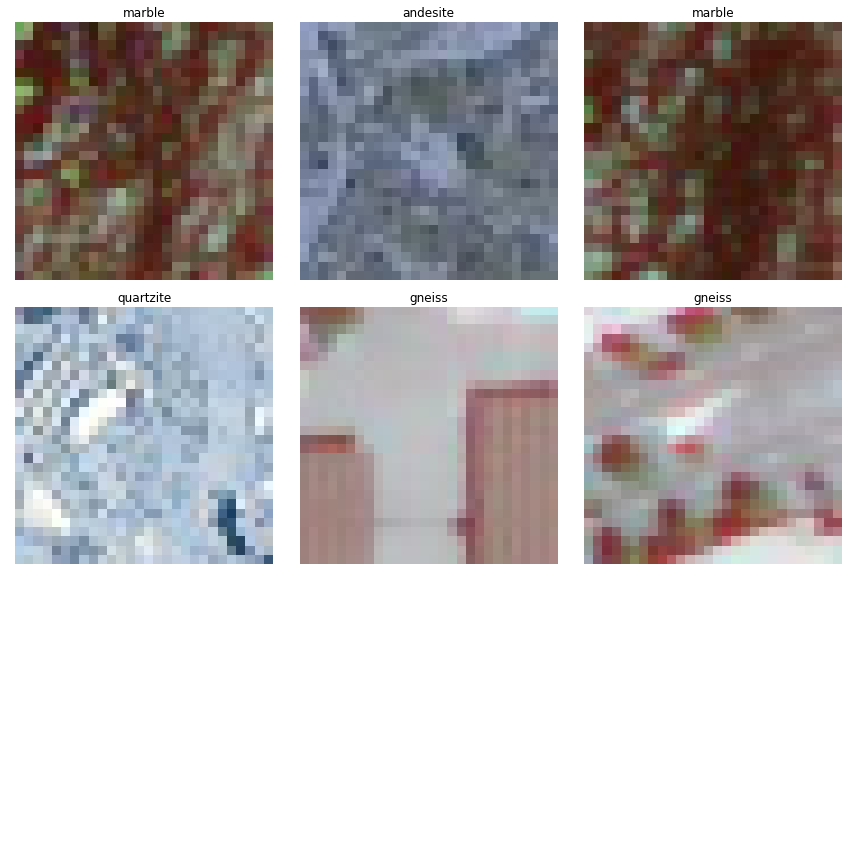

andesite
/home/pr916/notebooks/geo_image_problem/geological_similarity/train/andesite/ZA6W4.jpg


Images similar to above based on Cosine distance: 


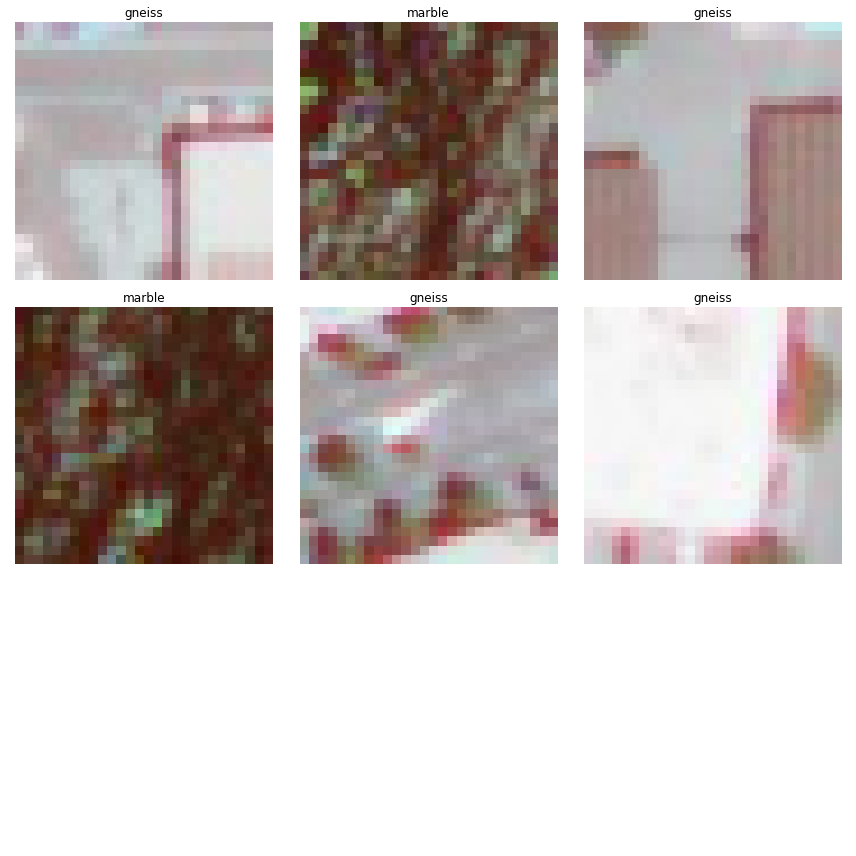

In [8]:
button = wg.Button(description="Load & Run the Model",
                  layout=Layout(width='250px',height='35px'))
rbutton = wg.Button(description="Show Results")
display(button)

def on_button_clicked(b):
    
    global img_repr_df
    global inference_data
    global show_results
    global learn
    global dist_type
    
    if model_selection.get_interact_value() == '':
        sys.exit('Run the tool again by \'Kernel->Restart & Run All\' and choose a model')
    if not architecture.get_interact_value()[-2:] == model_selection.get_interact_value()[-2:]:
        sys.exit('Run the tool again by \'Kernel->Restart & Run All\, ensure if model name and model type are consistent')

    if architecture.get_interact_value() == 'resnet18':
        arch = models.resnet18 
    if architecture.get_interact_value() == 'resnet34':
        arch = models.resnet34 
    if architecture.get_interact_value() == 'resnet50':
        arch = models.resnet50
    if architecture.get_interact_value() == 'resnet101':
        arch = models.resnet101

    geo_data, tfms = load_lib.load_and_restruct_data(dir_path = conf_lib.dir_path,
                                                     image_folder = conf_lib.image_folder,
                                                     image_size = conf_lib.image_size,
                                                     ratio_train = conf_lib.ratio_train,
                                                     ratio_test = conf_lib.ratio_test,
                                                     ratio_valid = conf_lib.ratio_valid,
                                                     data_folder_list = conf_lib.data_folder_list,
                                                     class_folder_list = conf_lib.class_folder_list,
                                                     aws_url = conf_lib.aws_url,
                                                     seed=42)

    print('geological image data loaded')

    test_data = (ImageList.from_folder(conf_lib.image_folder)
                .split_by_folder(train='train', valid='test')
                .label_from_folder()
                .transform(tfms)
                .databunch()
                .normalize())

    learn = cnn_learner(geo_data, arch, metrics=error_rate)
    learn = learn.load(model_selection.get_interact_value())

    class Hook():
        "Create a hook on `m` with `hook_func`."
        def __init__(self, m:nn.Module, hook_func:HookFunc, is_forward:bool=True, detach:bool=True):
            self.hook_func, self.detach, self.stored = hook_func, detach, None
            f = m.register_forward_hook if is_forward else m.register_backward_hook
            self.hook = f(self.hook_fn)
            self.removed = False

        def hook_fn(self, module:nn.Module, input:Tensors, output:Tensors):
            if self.detach:
                input  = (o.detach() for o in input ) if is_listy(input ) else input.detach()
                output = (o.detach() for o in output) if is_listy(output) else output.detach()
            self.stored = self.hook_func(module, input, output)

        def remove(self):
            if not self.removed:
                self.hook.remove()
                self.removed=True

        def __enter__(self, *args): return self
        def __exit__(self, *args): self.remove()

    output_layer = lib.get_named_module_from_model(learn.model, '1.5')

    train_images = geo_data.train_ds
    valid_images = geo_data.valid_ds
    test_images = test_data.valid_ds

    print('collecting all images ...')
    tvt_images_df = train_images.to_df().append(valid_images.to_df(), sort=False).reset_index(drop=True)
    tvt_images_df = tvt_images_df.append(test_images.to_df(), sort=False).reset_index(drop=True)
    tvt_images_df.columns = ['image','category']
    inference_data_source = (ImageList.from_df(df=tvt_images_df,
                                              path=conf_lib.image_folder,
                                              cols='image').split_none().label_from_df(cols='category'))

    inference_data = inference_data_source.transform(tfms, size=conf_lib.image_size).databunch(bs=32).normalize(imagenet_stats)
    inference_dataloader = inference_data.train_dl
    
    print('making image dataframe ...')
    str_time = time.time()
    img_repr_map = {}
    with Hook(output_layer, lib.get_output, True, True) as hook:
        for i, (xb,yb) in enumerate(inference_dataloader):
            bs = xb.shape[0]
            img_ids = inference_dataloader.items[i*bs:(i+1)*bs]
            result = learn.model.eval()(xb)
            img_reprs = hook.stored.cpu().numpy()
            img_reprs = img_reprs.reshape(bs, -1)
            for img_id, img_repr in zip(img_ids, img_reprs):
                img_repr_map[img_id] = img_repr

    img_repr_df = pd.DataFrame(img_repr_map.items(), columns=['img_id', 'img_repr'])
    img_repr_df['label'] = [inference_data.classes[x] for x in inference_data.train_ds.y.items[0:img_repr_df.shape[0]]]
    img_repr_df['label_id'] = inference_data.train_ds.y.items[0:img_repr_df.shape[0]]

    train_df = img_repr_df[img_repr_df['img_id'].str.contains('train')]
    valid_df = img_repr_df[img_repr_df['img_id'].str.contains('valid')]
    test_df = img_repr_df[img_repr_df['img_id'].str.contains('test')]

    train_ids = []; valid_ids = []; test_ids = []
    for i in range(6):
        train_ids.append(train_df[train_df['label'] == geo_data.classes[i]].index[0])
        valid_ids.append(valid_df[valid_df['label'] == geo_data.classes[i]].index[0])
        test_ids.append(test_df[test_df['label'] == geo_data.classes[i]].index[0])
    print('Indexes in order of ', [geo_data.classes[i] for i in range(6)])
    print('first indexes of each class type:', train_ids)
    print('first indexes of each class type:', valid_ids)
    print('first indexes of each class type:', test_ids)
    print('maximum image index:', len(img_repr_df))
    print('--------', round(time.time()-str_time), 'seconds --------')
    
    def on_rbutton_clicked(b):
        
        global img_repr_df
        global inference_data
        global show_results
        global learn
        global dist_type
        
        d_type = 'angular' if dist_type.get_interact_value() == 'Cosine' else 'euclidean'
        
        def show_results(ind, k):
            image_id = ind
            base_image, base_label, similar_images_df = lib.get_similar_images_annoy(image_id, 
                                                                                     img_repr_df, 
                                                                                     inference_data, 
                                                                                     d_type, k)
            image_path = img_repr_df.iloc[image_id, [0,1,2]].img_id
            print(base_label)
            print(base_image)
            display(Image(filename=image_path, width=256, height=256))
            print('Images similar to above based on', dist_type.get_interact_value(), 'distance: ')
            lib.show_similar_images(similar_images_df, learn)
        
        show_results(int(img_index.get_interact_value()),int(top_k.get_interact_value()))
    
    rbutton.on_click(on_rbutton_clicked)
    
    display(HBox([Box1,Box2]))
    display(rbutton)
    
button.on_click(on_button_clicked)

In [9]:
# def show_results(ind, k):

#     image_id = ind
#     base_image, base_label, similar_images_df = lib.get_similar_images_annoy(image_id, img_repr_df, inference_data, k)
#     image_path = img_repr_df.iloc[image_id, [0,1,2]].img_id
#     print(base_label)
#     print(base_image)
#     display(Image(filename=image_path, width=256, height=256))
#     print('Images similar to above based on', conf_lib.sim_dist_type, 'distance: ')
#     lib.show_similar_images(similar_images_df, learn)

In [10]:
# show_results(int(img_index.get_interact_value()),int(top_k.get_interact_value()))